In [1]:
import cpr_gym
import itertools
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

print(cpr_gym.engine.cpr_lib_version)

local-v0.1-92-g7952c6a-dirty


In [2]:
protocol_dict = dict(
    nakamoto=cpr_gym.protocols.nakamoto(),
    tailstorm8constant=cpr_gym.protocols.tailstorm(k=8, reward="constant"),
    tailstorm8discount=cpr_gym.protocols.tailstorm(k=8, reward="discount"),
)


def sparse(n_pow=None, protocol=None, **kwargs):
    env = gym.make(
        "cpr_gym:core-v0", proto=protocol_dict[protocol], **kwargs, max_steps=n_pow
    )
    env = cpr_gym.wrappers.SparseRewardPerBlockWrapper(env)
    return env


def dense(n_pow=None, protocol=None, **kwargs):
    env = gym.make("cpr_gym:core-v0", proto=protocol_dict[protocol], **kwargs)
    env = cpr_gym.wrappers.DenseRewardPerBlockWrapper(env, n_pow=n_pow)
    return env


env_dict = dict(sparse=sparse, dense=dense)


def run_episode(env, policy=None):
    p = lambda obs: env.policy(obs, policy)
    obs = env.reset()
    acc = 0
    done = False
    while not done:
        obs, reward, done, info = env.step(p(obs))
        acc += reward
    info["episode_reward"] = acc
    return info


def measure(env="sparse", n_episodes=1, policy="honest", **kwargs):
    env = env_dict[env](**kwargs)
    rewards = []
    runtime = []
    for i in range(n_episodes):
        try:
            info = run_episode(env, policy=policy)
            rewards.append(info["episode_reward"] / kwargs["alpha"])
            runtime.append(info["simulator_clock_rewarded"])
        except ValueError as e:
            warnings.warn(str(e))
            print(kwargs)
            print(f"policy: {policy}")
            print(e)
    return [np.median(rewards), np.median(runtime)]


alpha = np.linspace(0.1, 1.0, 10)
n_pow = [8, 16, 32, 64, 128]

dfs = []
for protocol in protocol_dict.keys():
    env = env_dict["sparse"](n_pow=128, protocol=protocol)
    df = pd.DataFrame(
        itertools.product([protocol], alpha, n_pow, env_dict.keys(), env.policies()),
        columns=["protocol", "alpha", "n_pow", "env", "policy"],
    )
    df["n_episodes"] = [int(np.ceil(1024 / x)) for x in df.n_pow]

    df[["reward", "runtime"]] = df.apply(
        lambda x: pd.Series(measure(**x)),
        axis=1,
    )
    dfs.append(df)
d = pd.concat(dfs, ignore_index=True)
d

/tmp/ipykernel_7087/680441306.py:47: UserWarning: ocaml error "Assert_failure ocaml/gym/engine.ml:284:4"
Raised at Dune__exe__Engine.of_module.step in file "ocaml/gym/engine.ml", line 284, characters 4-52
Called from Dune__exe__Bridge.(fun) in file "ocaml/gym/bridge.ml", line 80, characters 27-43
Called from Python_lib__Defunc.apply.loop in file "src/defunc.ml", line 123, characters 8-11
Called from Python_lib__Defunc.apply in file "src/defunc.ml", line 179, characters 23-47
Called from Python_lib__Py_module.wrap_ocaml_errors in file "src/py_module.ml", line 38, characters 6-10

  warnings.warn(str(e))


{'protocol': 'tailstorm8discount', 'alpha': 0.2, 'n_pow': 128}
policy: release-block
ocaml error "Assert_failure ocaml/gym/engine.ml:284:4"
Raised at Dune__exe__Engine.of_module.step in file "ocaml/gym/engine.ml", line 284, characters 4-52
Called from Dune__exe__Bridge.(fun) in file "ocaml/gym/bridge.ml", line 80, characters 27-43
Called from Python_lib__Defunc.apply.loop in file "src/defunc.ml", line 123, characters 8-11
Called from Python_lib__Defunc.apply in file "src/defunc.ml", line 179, characters 23-47
Called from Python_lib__Py_module.wrap_ocaml_errors in file "src/py_module.ml", line 38, characters 6-10



,protocol,alpha,n_pow,env,policy,n_episodes,reward,runtime
0,nakamoto,0.1,8,sparse,sapirshtein-2016-sm1,128,0.0,7.492176
1,nakamoto,0.1,8,sparse,eyal-sirer-2014,128,0.0,7.804534
2,nakamoto,0.1,8,sparse,simple,128,0.0,7.774885
3,nakamoto,0.1,8,sparse,honest,128,0.0,7.354445
4,nakamoto,0.1,8,dense,sapirshtein-2016-sm1,128,0.0,8.463078
...,...,...,...,...,...,...,...,...
1195,tailstorm8discount,1.0,128,sparse,honest,8,1.0,124.179993
1196,tailstorm8discount,1.0,128,dense,override-catchup,8,1.0,1302.829828
1197,tailstorm8discount,1.0,128,dense,override-block,8,1.0,1280.418232
1198,tailstorm8discount,1.0,128,dense,release-block,8,1.0,124.254473


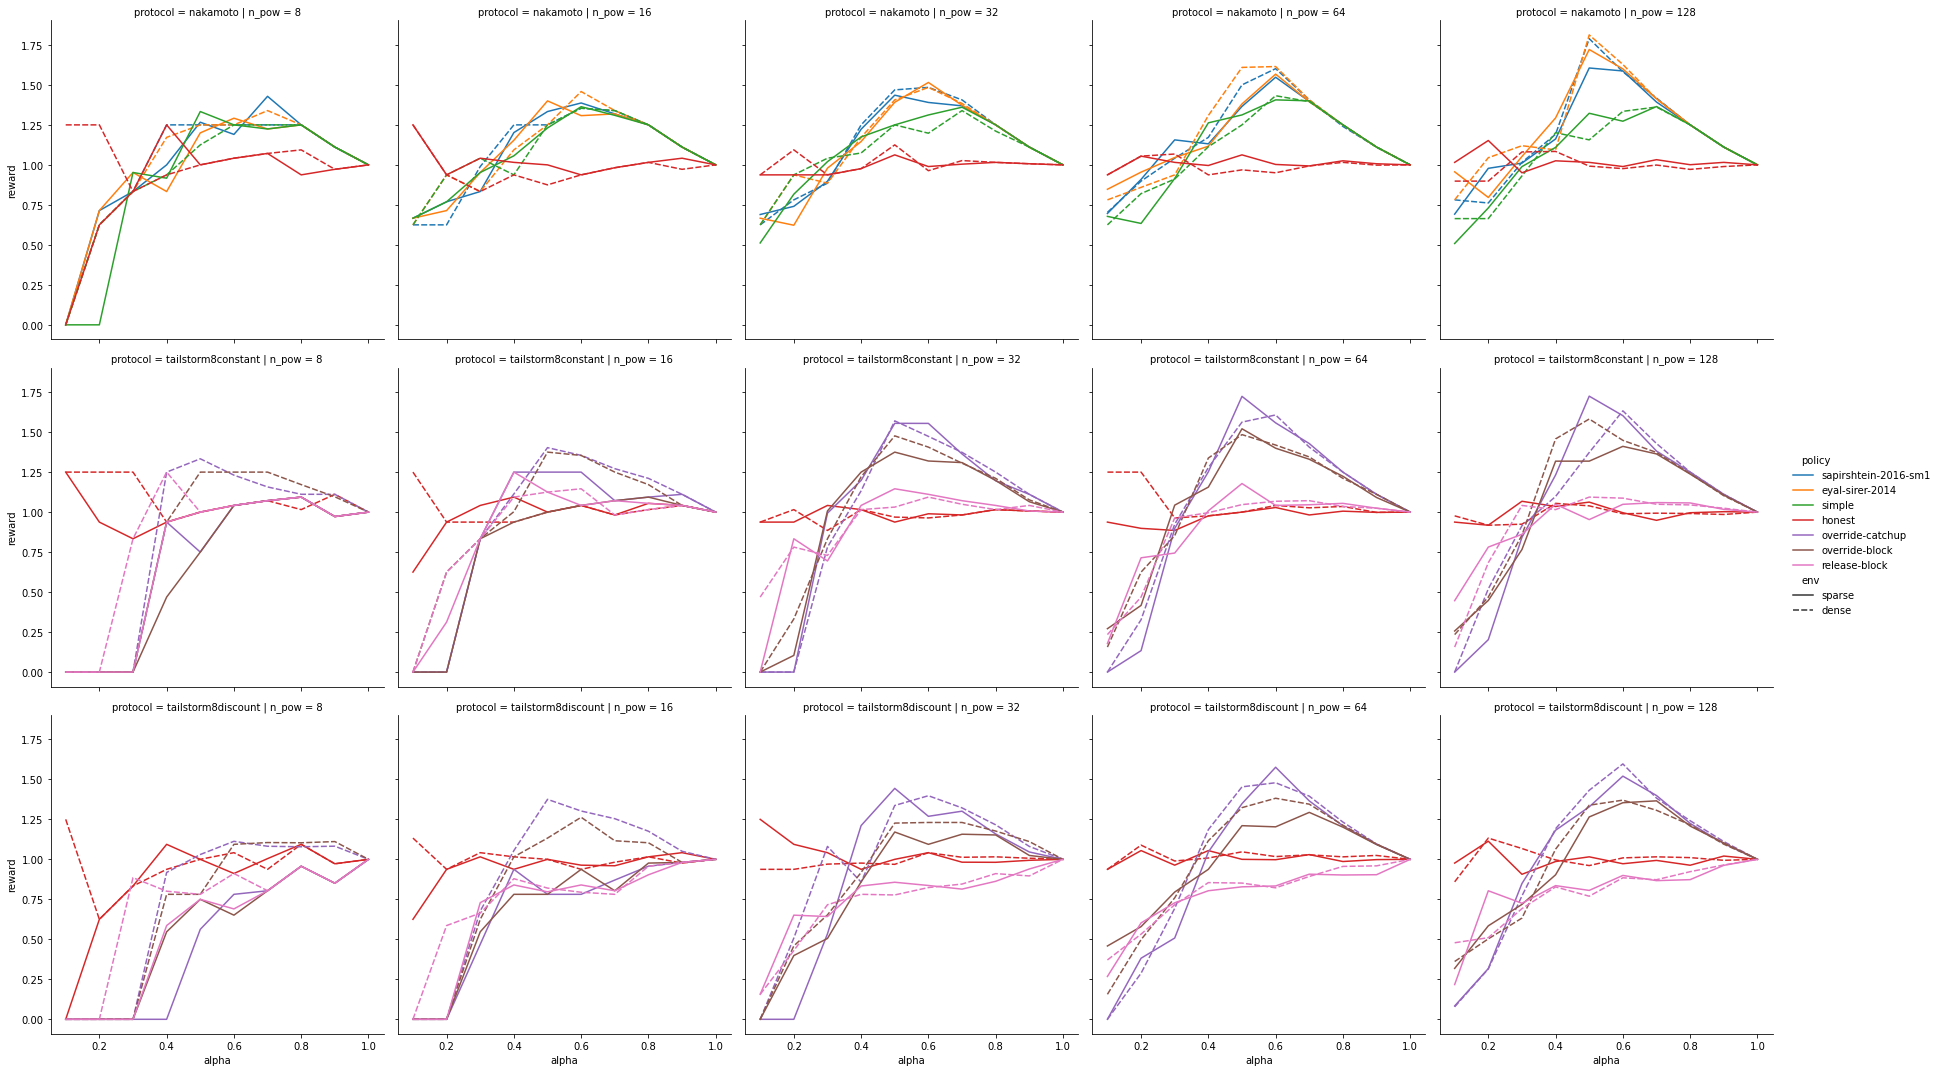

In [3]:
sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="reward",
    hue="policy",
    style="env",
    col="n_pow",
    row="protocol",
)

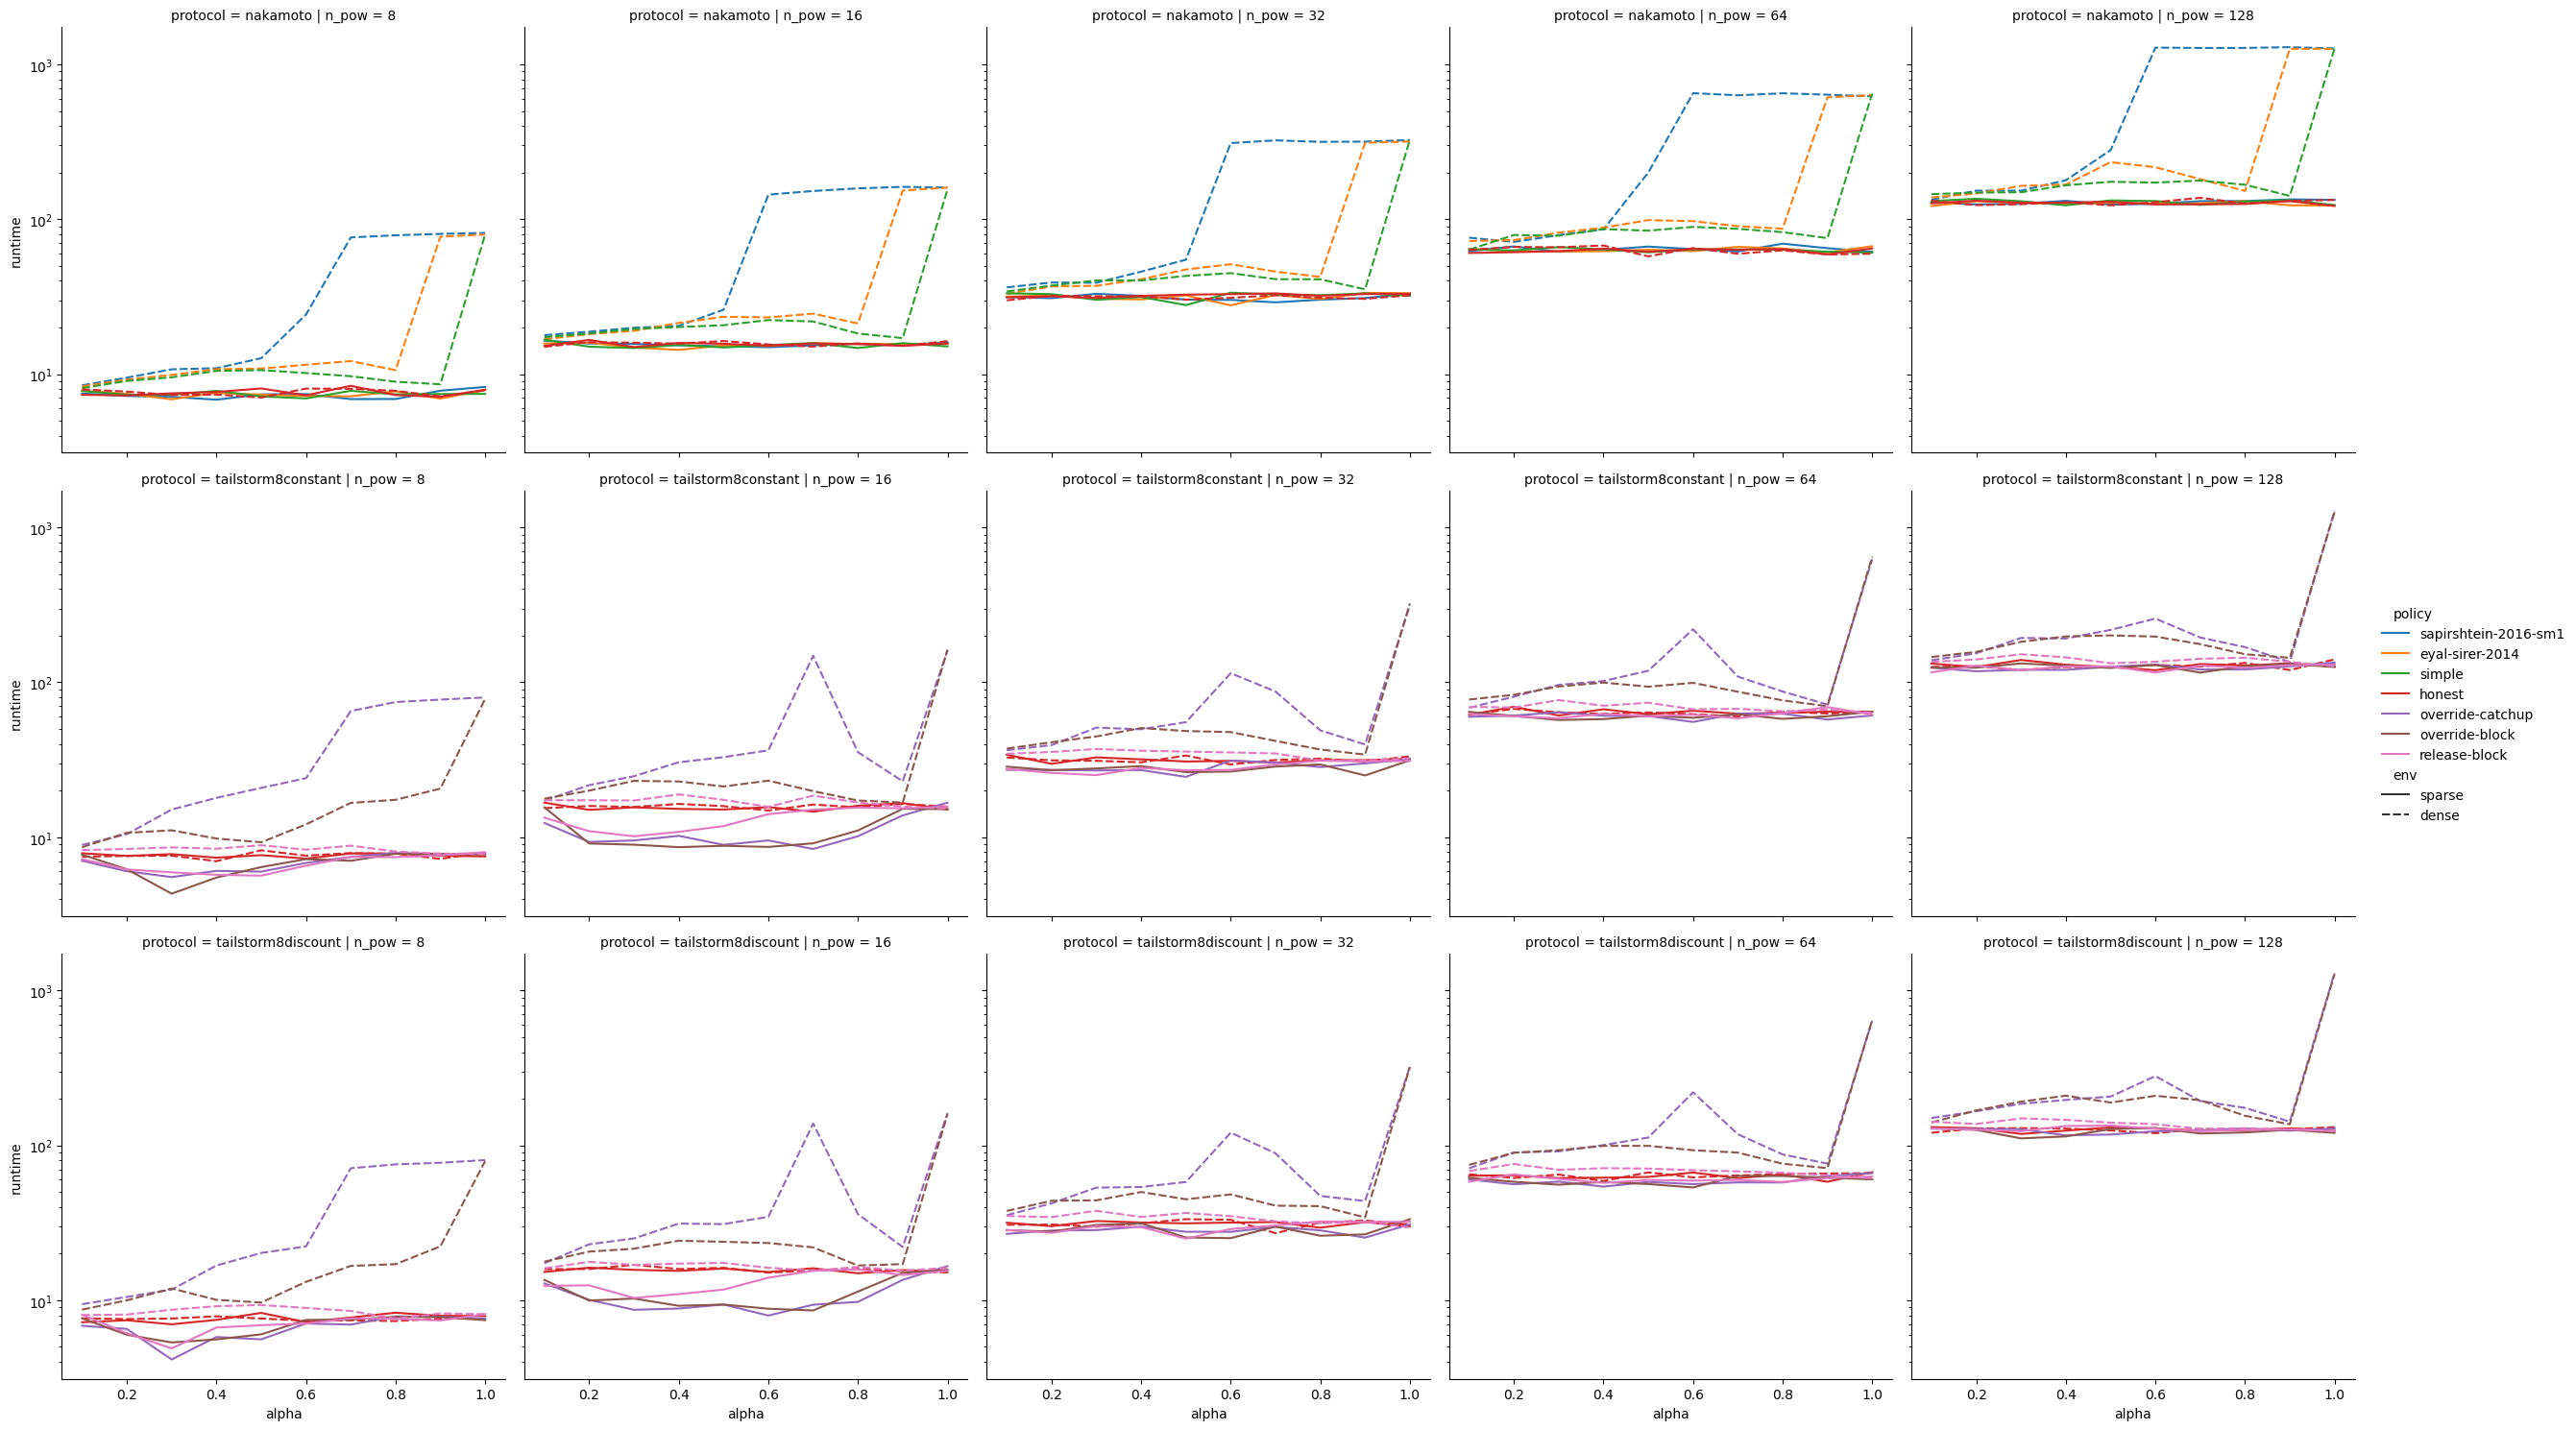

In [5]:
g = sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="runtime",
    hue="policy",
    style="env",
    col="n_pow",
    row="protocol",
)
g.set(yscale="log")